# LSTM time series + stock price prediction = <font color='red'>FAIL</font>
All too frequently when learning about time series prediction using artificial neural networks the temptation is to go right ahead and apply one to predicting the future price of either individual stocks, or the values of a stock market. In this little notebook we shall apply an LSTM (Long short-term memory) artificial neural network to the prediction of the [Spanish IBEX35 stock market](https://www.bolsamadrid.es/ing/indices/ibex/PreguntasClaveIbex35.aspx), and see that there is something going *very* wrong...

In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
from numpy.random import seed
seed(0)

# 1. Obtain the stock market data
We shall install the package [yfinance](https://github.com/ranaroussi/yfinance), the **Yahoo! Finance market data downloader**.

In [3]:
!pip -q install yfinance
import yfinance as yf

You should consider upgrading via the 'd:\development\softwares\venv\scripts\python.exe -m pip install --upgrade pip' command.


and for this notebook we shall use data from the IBEX35 stock market

In [4]:
IBEX = yf.Ticker("^IBEX")
IBEX.info

{'exchange': 'MCE',
 'shortName': 'IBEX 35...',
 'exchangeTimezoneName': 'Europe/Madrid',
 'exchangeTimezoneShortName': 'CEST',
 'isEsgPopulated': False,
 'gmtOffSetMilliseconds': '7200000',
 'quoteType': 'INDEX',
 'symbol': '^IBEX',
 'messageBoardId': 'finmb_INDEXIBEX',
 'market': 'es_market',
 'previousClose': 8503.7,
 'regularMarketOpen': 8536.1,
 'twoHundredDayAverage': 8700.183,
 'trailingAnnualDividendYield': None,
 'payoutRatio': None,
 'volume24Hr': None,
 'regularMarketDayHigh': 8546.4,
 'navPrice': None,
 'averageDailyVolume10Day': 181567480,
 'totalAssets': None,
 'regularMarketPreviousClose': 8503.7,
 'fiftyDayAverage': 8439.052,
 'trailingAnnualDividendRate': None,
 'open': 8536.1,
 'toCurrency': None,
 'averageVolume10days': 181567480,
 'expireDate': None,
 'yield': None,
 'algorithm': None,
 'dividendRate': None,
 'exDividendDate': None,
 'beta': None,
 'circulatingSupply': None,
 'startDate': None,
 'regularMarketDayLow': 8432.9,
 'priceHint': 2,
 'currency': 'EUR',
 'r

Let us load in the data from the start of 2016

In [6]:
# get historical market data
IBEX_values = IBEX.history(start="2016-01-01",end="2021-03-01")

What does this dataframe look like

In [7]:
IBEX_values

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-12-31,9604.190368,9615.589771,9538.790045,9544.190430,79920900,0,0
2016-01-04,9429.789917,9440.890491,9263.690482,9313.190430,279173100,0,0
2016-01-05,9431.490134,9446.190314,9260.190508,9335.190430,208637600,0,0
2016-01-06,9330.289898,9330.289898,9122.589923,9197.390625,288658500,0,0
2016-01-07,8973.791099,9102.991169,8889.691571,9059.291016,395763700,0,0
...,...,...,...,...,...,...,...
2021-02-22,8119.600098,8126.299805,8045.299805,8112.200195,221465900,0,0
2021-02-23,8128.000000,8259.900391,8107.600098,8252.099609,293160800,0,0
2021-02-24,8266.599609,8311.500000,8205.200195,8269.599609,225852700,0,0


let us plot this data, in particular the ``Close`` value

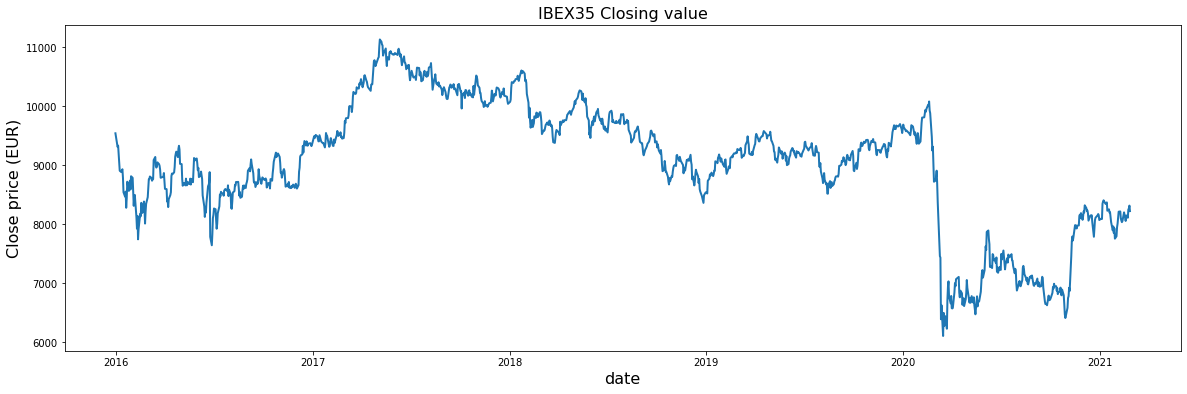

In [8]:
plt.figure(figsize=(20,6))
plt.plot(IBEX_values.index, IBEX_values['Close'], lw=2)
plt.xlabel("date")
plt.xlabel("date", fontsize=16)
plt.ylabel("Close price (EUR)", fontsize=16)
plt.title("IBEX35 Closing value", fontsize=16);

# 2. Create our training and test data
For the purposes of this exercise let us use the four years of data before the year 2020 as our training data, and use the data from the beginning of 2020 onward for prediction

In [11]:
# convert the Date column into a pandas datatime format
IBEX_values.index = pd.to_datetime(IBEX_values.index)

In [12]:
from sklearn.preprocessing import MinMaxScaler
# rescale the whole dataset (ideally this shoud be done seperately on the train and test data in order to prevent data leakage, in particular 'look-ahead bias')
scaler = MinMaxScaler(feature_range=(0, 1))
#train_series = scaler.fit_transform(train_series)
IBEX_values['Close'] = scaler.fit_transform(IBEX_values[['Close']])

In [13]:
# train / test split
train_data = IBEX_values.query('Date <  "2020-01-01"').reset_index(drop = False) 
test_data  = IBEX_values.query('Date >= "2020-01-01"').reset_index(drop = False)

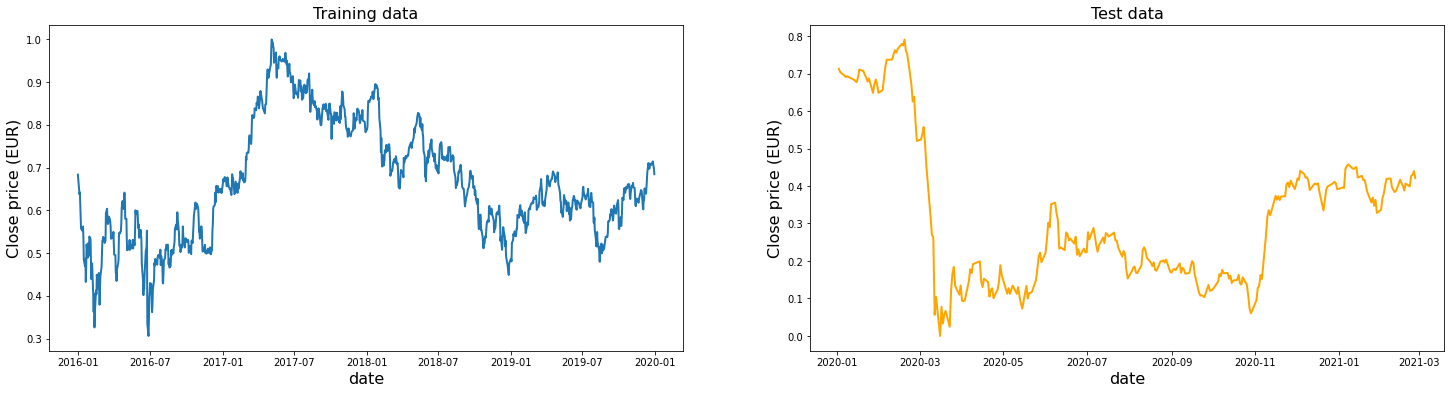

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 6))
ax1.plot(train_data.Date, train_data['Close'], lw=2)
ax1.set_xlabel("date", fontsize=16)
ax1.set_ylabel("Close price (EUR)", fontsize=16)
ax1.set_title("Training data", fontsize=16)
ax2.plot(test_data.Date, test_data['Close'], c='orange', lw=2)
ax2.set_xlabel("date", fontsize=16)
ax2.set_ylabel("Close price (EUR)", fontsize=16)
ax2.set_title("Test data", fontsize=16);

# 3. Our LSTM neural network
For our neural network we shall use the very same one that was used successfully to predict a sine wave in my notebook ["*LSTM time series prediction: sine wave example*"](https://www.kaggle.com/carlmcbrideellis/lstm-time-series-prediction-sine-wave-example)

In [15]:
X_train = train_data.Date
y_train = train_data['Close']

X_test = test_data.Date
y_test = test_data['Close']

n_features = 1

train_series = y_train.values.reshape((len(y_train), n_features))
test_series  = y_test.values.reshape((len(y_test), n_features))

we shall be using a ``look_back = 20``. This means that we shall be using 20 previous data points in order to predict the next data point

In [16]:
%%time

from keras.preprocessing.sequence import TimeseriesGenerator

look_back = 20

train_generator = TimeseriesGenerator(train_series, train_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 10)

test_generator = TimeseriesGenerator(test_series, test_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 10)

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

n_neurons  = 4
model = Sequential()
model.add(LSTM(n_neurons, input_shape=(look_back, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');

model.fit(train_generator,epochs=300, verbose=0);

CPU times: total: 8min 52s
Wall time: 4min 10s


In [17]:
test_predictions  = model.predict(test_generator)

In [19]:
# uncomment to undo the scaling
test_data['Close'] = scaler.inverse_transform(test_data[['Close']])
test_predictions   = scaler.inverse_transform(test_predictions)

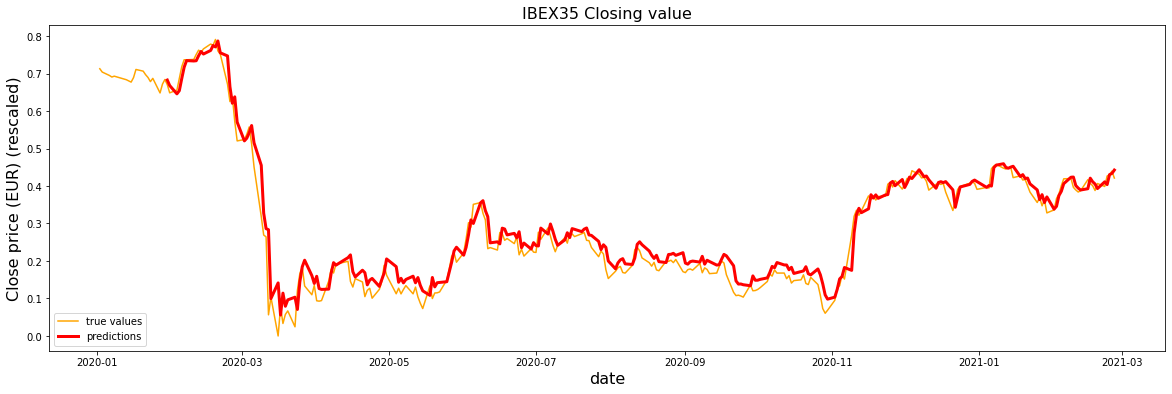

In [20]:
plt.figure(figsize=(20,6))
plt.plot(test_data.Date, test_data['Close'], c='orange',label='true values')
plt.plot(X_test[20:],test_predictions, lw=3, c='r',linestyle = '-', label='predictions')
plt.legend(loc="lower left")
plt.xlabel("date", fontsize=16)
plt.ylabel("Close price (EUR) (rescaled)", fontsize=16)
plt.title("IBEX35 Closing value", fontsize=16);

# Wow, that is amazingly good!
Our LSTM neural network seems to do a wonderful job, it even predicts the huge 'COVID' drop seen around March 2020. 

...but wait, *how is that even possible if there was no 'COVID' like drop in the training data?!... hmm*

Let us take a closer look at the last 20 days of test data, along with our predictions (note that there is no data on the weekends)

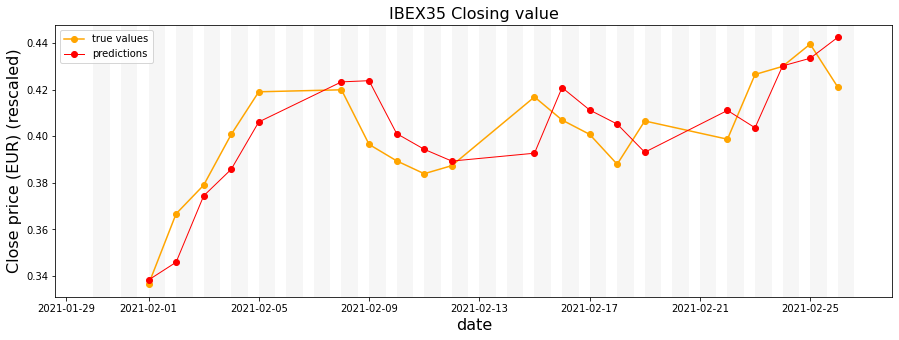

In [53]:
n_days = 20
last_n_days = len(test_data)-n_days

plt.figure(figsize=(15,5))
plt.plot(test_data.Date[last_n_days:], test_data['Close'][last_n_days:], c='orange',marker='o',label='true values')
plt.plot(X_test[last_n_days:],test_predictions[last_n_days-n_days:],lw=1, c='r', marker='o', label='predictions')
plt.legend(loc="upper left")
plt.xlabel("date", fontsize=16)
plt.ylabel("Close price (EUR) (rescaled)", fontsize=16)
plt.title("IBEX35 Closing value", fontsize=16)

# shade in the days for better visualization
date2 = IBEX_values.tail(1).index.item()
date1 = date2 - pd.Timedelta(days=n_days+7) # days added for weekends etc.
for i in pd.date_range(date1, date2, periods=n_days+8):
    # shade in 0.6 of each day
    plt.axvspan(i,i+pd.Timedelta(days=0.6), facecolor='lightgrey', alpha=0.2)
plt.show();

we can see on this scale that what is actually happening is that our predictions for each day are basically the value of the day before, plus a little extra!

# 4. Extrapolation: Ok, maybe not *so* good after all...
This time, rather than looking back on the last 20 test data values and predicting only the very next value, we shall now keep the prediction value, and store it as part of our input data


In [23]:
extrapolation = list()
seed_batch    = y_test[:look_back].values.reshape((1,look_back, n_features))
current_batch = seed_batch

for i in range(len(test_data)):
    predicted_value = model.predict(current_batch)[0]
    extrapolation.append(predicted_value) 
    current_batch = np.append(current_batch[:,1:,:],[[predicted_value]],axis=1)

now let us take a look at the results, and see our LSTM model in all its glory

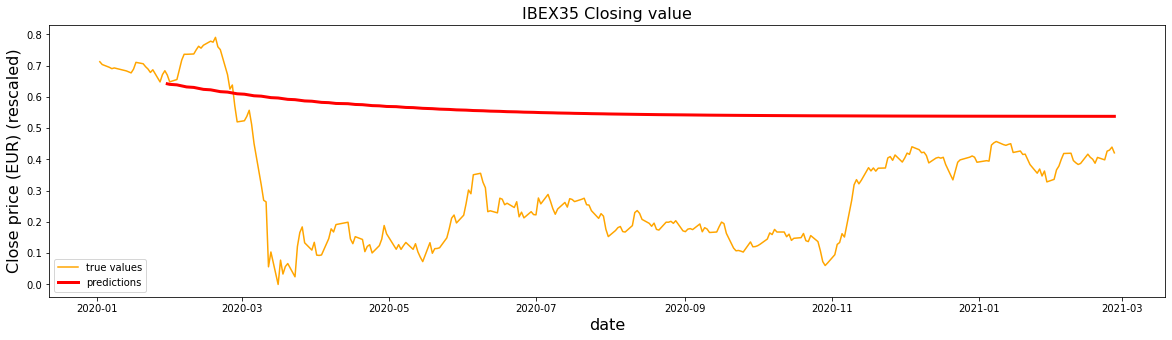

In [24]:
plt.figure(figsize=(20,5))
plt.plot(test_data.Date, test_data['Close'], c='orange',label='true values')
plt.plot(X_test[20:],extrapolation[20:], lw=3, c='r',linestyle = '-', label='predictions')
plt.legend(loc="lower left")
plt.xlabel("date", fontsize=16)
plt.ylabel("Close price (EUR) (rescaled)", fontsize=16)
plt.title("IBEX35 Closing value", fontsize=16);

we can now see what is *really* going on; the neural net is predicting that today's stock price is basically yesterdays stock price + a little (hence the slight gradient). Our initial predictions looked good because, on a large scale, we do not notice that our model was basically mimicking yesterdays price.

# 5. What went wrong?
Why did we fail?  There is far more going on in the stock market data than can be captured simply by looking at a univariate series of historical values. The stock prices are not the result of a couple of underlying causal factors, but a rather a multitude of contributions as well as a good dose of human irrationality (*Kahneman, Thaler*). Indeed it has been posited that stock data is almost random (*Fama, Malkiel*).

Let us plot a histogram of the daily percentage change in the `Close` value in our training data, and compare it to a [normal distribution, as obtained from the central limit theorem](https://www.kaggle.com/carlmcbrideellis/animated-histogram-of-the-central-limit-theorem):

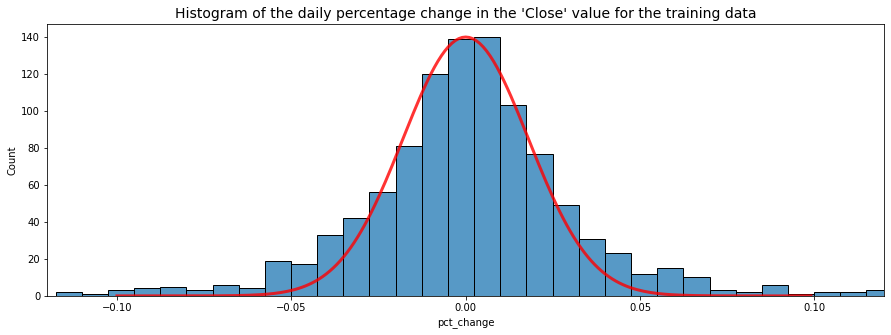

In [25]:
train_data['pct_change'] = train_data.Close.pct_change(periods = 1)

x = np.arange(-0.1, 0.1, 0.001)

# define a Gaussian function
def Gaussian(x,mu,sigma,A):
    return A*np.exp(-0.5 * ((x-mu)/sigma)**2)

plt.figure(figsize = (15,5))
ax = sns.histplot(train_data['pct_change'], binwidth=0.0075)
# overlay a Gaussian distribution, parameters were picked by eye
ax = plt.plot(x,Gaussian(x,0,0.018,140),color='r',lw=3,label='Gaussian #1', alpha=0.8)
plt.title("Histogram of the daily percentage change in the 'Close' value for the training data", size=14)
plt.xlim(-0.12, 0.12);

Indeed it looks almost normal, although with some heavy tails. Could our training data really be just a [random walk](https://en.wikipedia.org/wiki/Random_walk)? One thing we can do is to look at a [correlogram](https://en.wikipedia.org/wiki/Correlogram). Given that the next point on a random walk starts out from the previous point, we must look at the differences between subsequent values, rather than the actual values themselves

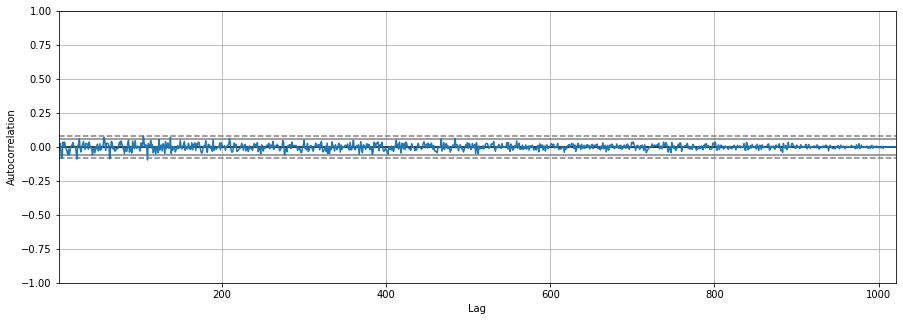

In [26]:
diff_train_data_close = train_data['Close'].diff()
# drop the initial nan
diff_train_data_close = diff_train_data_close.dropna()
# now for the autocorrelation plot
rcParams['figure.figsize'] = 15, 5
pd.plotting.autocorrelation_plot(diff_train_data_close);

It certainly look like we are dealing with a random walk, as there are no indications of any autocorrelation for any lag. 

Basically our LSTM found nothing of any real value to model and thus took the average value, along with a slight slope; we would have been just as well off with 
an extremely simplistic model of the form

$$ \mathrm{Close}_t \propto \mathrm{Close}_{(t-1)} $$

This is known as the naïve forecast, or persistence model. For a random walk, given that by definition the next value cannot be predicted, then using the current value for the next value, *i.e.*, the one-step naïve forecast, theoretically gives the best possible results.

Let us compare our LSTM model with such a naïve forecast

In [42]:
# create a naïve forecast
test_data['naive'] = test_data['Close'].shift(1)

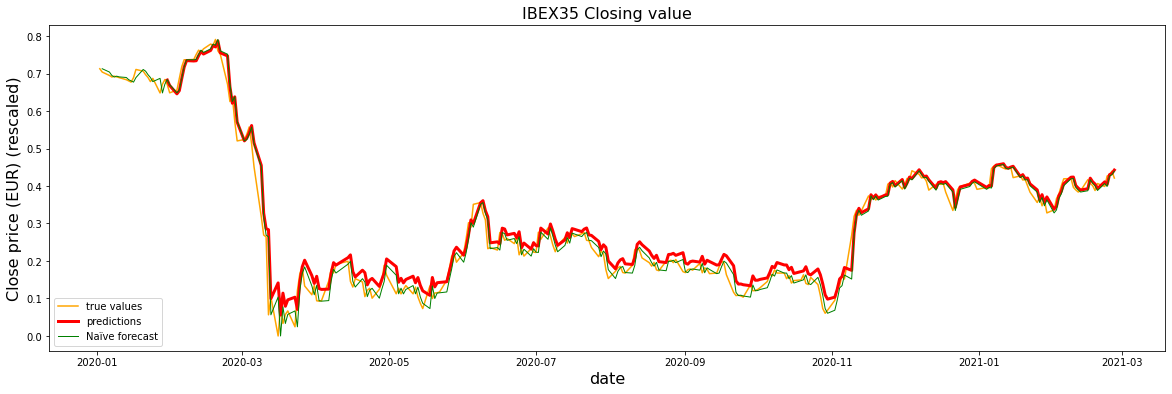

In [43]:
plt.figure(figsize=(20,6))
plt.plot(test_data.Date, test_data['Close'], c='orange',label='true values')
plt.plot(X_test[20:],test_predictions, lw=3, c='r',linestyle = '-', label='predictions')
plt.plot(test_data.Date,test_data['naive'], lw=1, c='green',linestyle = '-', label='Naïve forecast')
plt.legend(loc="lower left")
plt.xlabel("date", fontsize=16)
plt.ylabel("Close price (EUR) (rescaled)", fontsize=16)
plt.title("IBEX35 Closing value", fontsize=16);

# Model performance
Let us now take a look at some performance metrics, namely the [mean squared error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) and the [mean absolute error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html):

In [29]:
# first create a pad of length "look_back"
twenty_zeros = np.zeros((look_back,1))
# now insert the LSTM predictions into the dataframe
test_data["LSTM"] = np.concatenate([twenty_zeros,test_predictions])

from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

print("Naïve model MSE: %.4f" % mean_squared_error(test_data[20:]["Close"], test_data[20:]["naive"]))
print("LSTM model  MSE: %.4f" % mean_squared_error(test_data[20:]["Close"], test_data[20:]["LSTM"]))
print("Naïve model MAE: %.4f" % median_absolute_error(test_data[20:]["Close"], test_data[20:]["naive"]))
print("LSTM model  MAE: %.4f" % median_absolute_error(test_data[20:]["Close"], test_data[20:]["LSTM"]))

Naïve model MSE: 0.0009
LSTM model  MSE: 0.0012
Naïve model MAE: 0.0151
LSTM model  MAE: 0.0199


we can clearly see that the naïve model easily outperforms the LSTM model.

# Conclusion

Let's face it, if it were so easy to predict stock prices using historic values + a very simple neural network, there would be *far less* notebooks on the subject, and *far* more people sipping champagne on the decks of their yachts whilst sailing around the Mediterranean sea.

# Related reading
* [Sepp Hochreiter and Jürgen Schmidhuber "Long Short-Term Memory", Neural Computation **9** pp. 1735-1780 (1997)](https://www.mitpressjournals.org/doi/pdf/10.1162/neco.1997.9.8.1735)
* [keras LSTM layers](https://keras.io/api/layers/recurrent_layers/lstm/)
* [Long short-term memory](https://en.wikipedia.org/wiki/Long_short-term_memory) on Wikipedia
* [yfinance](https://github.com/ranaroussi/yfinance)  **Yahoo! Finance market data downloader**.
* Daniel Kahneman "*Thinking, Fast and Slow*", Farrar, Straus and Giroux (2011)
* Richard H. Thaler "*Misbehaving: The Making of Behavioral Economics*", W. W. Norton & Company (2015)
* [Eugene F. Fama "*Random Walks in Stock Market Prices*", Financial Analysts Journal **21** pp. 55-59 (1965)](https://doi.org/10.2469/faj.v21.n5.55)
* Burton G. Malkiel "*A Random Walk Down Wall Street*", W. W. Norton & Company (1973)
* Fred Schwed "*Where Are the Customers' Yachts?*", Simon & Schuster (1940)
* [Rob J. Hyndman and George Athanasopoulos "*Forecasting: Principles and Practice*", (3rd Edition)](https://otexts.com/fpp3/)
* [Fotios Petropoulos, *et al. "Forecasting: Theory and Practice*", arXiv:2012.03854 (2020)](https://arxiv.org/pdf/2012.03854.pdf)
* [Hansika Hewamalage , *et al. "Forecast Evaluation for Data Scientists: Common Pitfalls and Best Practices*", arXiv:2203.10716 (2022)](https://arxiv.org/pdf/2203.10716.pdf)